In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

data2015 = pd.read_csv('data2015_noEss.csv', sep=',')
data2015 = data2015.drop(columns='Unnamed: 0')
data2015 = data2015.dropna()

In [2]:
#Features utilisees selon l'analyse effectuee dans 'features_pertinentes_SiteEnergyUse.ipynb' + SiteEnergyUse (cible de la prediction)
data2015 = data2015[['NumberofFloors', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)']]

#On effectue une transformation x -> log(x + 1) (on evite les 0 se transformant en moins l'infini)
data2015['LargestPropertyUseTypeGFA'] = np.log(data2015['LargestPropertyUseTypeGFA'] + 1)
data2015['PropertyGFAParking'] = np.log(data2015['PropertyGFAParking'] + 1)
data2015['SecondLargestPropertyUseTypeGFA'] = np.log(data2015['SecondLargestPropertyUseTypeGFA'] + 1)
data2015['ThirdLargestPropertyUseTypeGFA'] = np.log(data2015['ThirdLargestPropertyUseTypeGFA'] + 1)
data2015['SiteEnergyUse(kBtu)'] = np.log(data2015['SiteEnergyUse(kBtu)'] + 1)

#On traite le cas de valeurs infinies creees par l'ordinateur, lors de la transformation des features quantitatives
data2015.replace([np.inf, -np.inf], np.nan)
data2015 = data2015.dropna()

data2015.shape

(1581, 8)

In [3]:
#On definit les colonnes et les transformations pour les colonnes quantitatives:
col_quanti = ['LargestPropertyUseTypeGFA', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
transfo_quanti = StandardScaler()

#On definit les colonnes et les transformations pour les variables qualitatives:
col_quali = ['NumberofFloors', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']
transfo_quali = OneHotEncoder(handle_unknown='ignore', sparse=False)

#On definit l'objet de la classe ColumnTransformer qui va permettre d'appliquer toutes les etapes:
preparation = ColumnTransformer([('quanti', transfo_quanti , col_quanti), ('quali', transfo_quali , col_quali)])

In [4]:
#On utilise les donnees contenues dans data2015:
x_train, x_test, y_train, y_test = train_test_split(data2015.iloc[:, :-1], data2015['SiteEnergyUse(kBtu)'], random_state=0)

In [ ]:
#--------------------------#

In [5]:
#Definition de listes pour enregistrer les resultats des metrics RMSE et Temps (entrainement et prediction):
liste_model = []
liste_rmse = []
liste_time_train = []
liste_time_predict = []

In [ ]:
#--------------------------#

In [6]:
#Baseline:
from sklearn.dummy import DummyRegressor

In [7]:
#On cree un pipeline de traitement integrant la preparation et le modele LinearRegression:
baseline = Pipeline(steps=[('preparation', preparation), ('dummyRegressor', DummyRegressor())])

#On ajuste le modele en utilisant les donnees d'apprentissage 
#Le modele comporte les transformations StandardScaler et OneHotEncoder, ainsi que le modele DummyRegressor

#Calcul du temps d'apprentissage
start = time.time()
baseline.fit(x_train, y_train)
stop = time.time()

liste_time_train.append(stop - start)

rmse_baseline = mean_squared_error(y_test, baseline.predict(x_test))
print("RMSE linReg = {:.3f}".format(rmse_baseline))

RMSE linReg = 1.910


In [8]:
#Stockage de la valeur RMSE pour ce modele:
liste_model.append('baseline')
liste_rmse.append(rmse_baseline)

In [9]:
#Calcul du temps de prediction:

x_train_transformed = preparation.fit_transform(x_train)
baseline = DummyRegressor().fit(x_train_transformed, y_train)

start = time.time()
baseline.predict(x_train_transformed)
stop = time.time()

liste_time_predict.append(stop - start)

In [ ]:
#--------------------------#

In [10]:
#modele lineaire - Lasso:
from sklearn.linear_model import Lasso

In [11]:
#On cree un pipeline de traitement integrant la preparation et le modele Lasso:
modele_lasso = Pipeline([('preparation', preparation), ('lasso', Lasso())])

#On definit les hyperparametres a faire varier:
param_grid = {'lasso__alpha': np.logspace(-4, 3, 8), 'lasso__max_iter':np.logspace(0, 4, 5)}

#On cree le modele de grille
grid = GridSearchCV(modele_lasso, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

#On entraine le modele
grid.fit(x_train, y_train)

print(grid.best_params_)

{'lasso__alpha': 0.001, 'lasso__max_iter': 10.0}


In [12]:
#Calcul du temps d'apprentissage et de prediction:

model_time_test = Lasso(alpha=0.001, max_iter= 10)

start = time.time()
model_time_test.fit(x_train_transformed, y_train)
stop = time.time()

liste_time_train.append(stop - start)

start = time.time()
model_time_test.predict(x_train_transformed)
stop = time.time()

liste_time_predict.append(stop - start)

In [13]:
rmse_lasso = mean_squared_error(y_test, grid.predict(x_test))
print("RMSE lasso = {:.3f}".format(rmse_lasso))

RMSE lasso = 0.574


In [14]:
#Stockage de la valeur RMSE pour ce modele:
liste_model.append('lasso')
liste_rmse.append(rmse_lasso)

In [ ]:
#--------------------------#

In [15]:
#modele lineaire - Ridge:
from sklearn.linear_model import Ridge

In [16]:
#On cree un pipeline de traitement integrant la preparation et le modele Ridge:
modele_ridge = Pipeline(steps=[('preparation', preparation), ('ridge', Ridge())])

#On definit l'hyperparametre a faire varier:
param_grid = {'ridge__alpha': np.logspace(-2, 4, 7)}

#On cree le modele de grille
grid = GridSearchCV(modele_ridge, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

#On entraine le modele
grid.fit(x_train, y_train)

print(grid.best_params_)

{'ridge__alpha': 10.0}


In [17]:
#Calcul du temps d'apprentissage et de prediction:

model_time_test = Ridge(alpha=10)

start = time.time()
model_time_test.fit(x_train_transformed, y_train)
stop = time.time()

liste_time_train.append(stop - start)

start = time.time()
model_time_test.predict(x_train_transformed)
stop = time.time()

liste_time_predict.append(stop - start)

In [18]:
rmse_ridge = mean_squared_error(y_test, grid.predict(x_test))
print("RMSE ridge = {:.3f}".format(rmse_ridge))

RMSE ridge = 0.562


In [19]:
#Stockage de la valeur RMSE pour ce modele:
liste_model.append('ridge')
liste_rmse.append(rmse_ridge)

In [ ]:
#--------------------------#

In [20]:
#modele SVM:
from sklearn.svm import SVR

In [ ]:
#noyau gaussien

In [21]:
#On cree un pipeline de traitement integrant la preparation et le modele SVR:
modele_svr = Pipeline(steps=[('preparation', preparation), ('svr', SVR())])

#On definit l'hyperparametre a faire varier:
param_grid = {'svr__C': np.logspace(-2, 2, 5)}

#On cree le modele de grille
grid = GridSearchCV(modele_svr, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

#On entraine le modele
grid.fit(x_train, y_train)

print(grid.best_params_)

{'svr__C': 1.0}


In [22]:
#Calcul du temps d'apprentissage et de prediction:

model_time_test = SVR(C=1)

start = time.time()
model_time_test.fit(x_train_transformed, y_train)
stop = time.time()

liste_time_train.append(stop - start)

start = time.time()
model_time_test.predict(x_train_transformed)
stop = time.time()

liste_time_predict.append(stop - start)

In [23]:
rmse_svr = mean_squared_error(y_test, grid.predict(x_test))
print("RMSE svr = {:.3f}".format(rmse_svr))

RMSE svr = 0.517


In [24]:
#Stockage de la valeur RMSE pour ce modele:
liste_model.append('svr')
liste_rmse.append(rmse_svr)

In [ ]:
#--------------------------#

In [25]:
#methode ensembliste - foret aleatoire
from sklearn.ensemble import RandomForestRegressor

In [26]:
#On cree un pipeline de traitement integrant la preparation et le modele RandomForestRegressor:
modele_rfr = Pipeline(steps=[('preparation', preparation), ('randomforestregressor', RandomForestRegressor(random_state=0))])

#On definit les hyperparametres a faire varier:
param_grid = {'randomforestregressor__n_estimators': [200, 350, 500], 'randomforestregressor__max_depth':[5, 10, 15]}

#On cree le modele de grille
grid = GridSearchCV(modele_rfr, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

#On entraine le modele
grid.fit(x_train, y_train)

print(grid.best_params_)

{'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 350}


In [27]:
#Calcul du temps d'apprentissage et de prediction:

model_time_test = RandomForestRegressor(max_depth=10, n_estimators= 350, random_state=0, n_jobs=-1)

start = time.time()
model_time_test.fit(x_train_transformed, y_train)
stop = time.time()

liste_time_train.append(stop - start)

start = time.time()
model_time_test.predict(x_train_transformed)
stop = time.time()

liste_time_predict.append(stop - start)

In [28]:
rmse_randomForest = mean_squared_error(y_test, grid.predict(x_test))
print("RMSE randomForest = {:.3f}".format(rmse_randomForest))

RMSE randomForest = 0.555


In [29]:
#Stockage de la valeur RMSE pour ce modele:
liste_model.append('randomForest')
liste_rmse.append(rmse_randomForest)

In [ ]:
#--------------------------#

In [30]:
#methode ensembliste - gradient boosted regression trees
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
#On cree un pipeline de traitement integrant la preparation et le modele GradientBoostingRegressor:
modele_gbr = Pipeline(steps=[('preparation', preparation), ('gradientboostingregressor', GradientBoostingRegressor(random_state=0))])

#On definit les hyperparametres a faire varier:
param_grid = {'gradientboostingregressor__n_estimators': [100, 200, 300], 'gradientboostingregressor__max_depth': [2, 3, 4], 'gradientboostingregressor__learning_rate': [0.01, 0.1, 1]}

#On cree le modele de grille
grid = GridSearchCV(modele_gbr, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

#On entraine le modele
grid.fit(x_train, y_train)

print(grid.best_params_)

{'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 200}


In [32]:
#Calcul du temps d'apprentissage et de prediction:

model_time_test = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=0)

start = time.time()
model_time_test.fit(x_train_transformed, y_train)
stop = time.time()

liste_time_train.append(stop - start)

start = time.time()
model_time_test.predict(x_train_transformed)
stop = time.time()

liste_time_predict.append(stop - start)

In [33]:
rmse_gradientBoosting = mean_squared_error(y_test, grid.predict(x_test))
print("RMSE gradientBoosting = {:.3f}".format(rmse_gradientBoosting))

RMSE gradientBoosting = 0.502


In [34]:
#Stockage de la valeur RMSE pour ce modele:
liste_model.append('gradientBoosting')
liste_rmse.append(rmse_gradientBoosting)

In [ ]:
#--------------------------#

In [ ]:
#On affiche l'erreur RMSE, le temps d'apprentissage et le temps de prediction pour chaque modele:

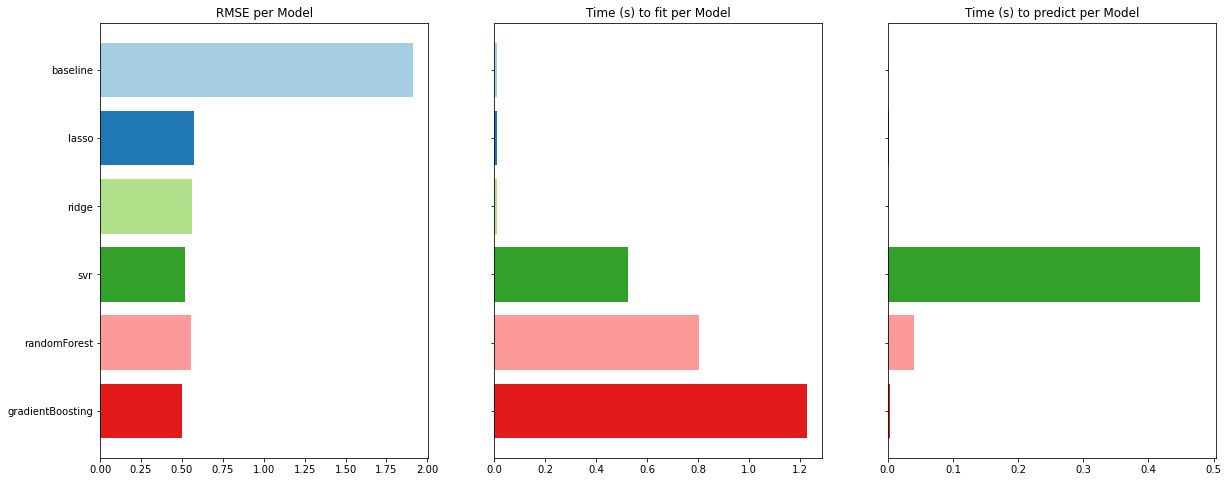

In [35]:
#Creation des 3 graphiques
f, axes = plt.subplots(1, 3, figsize=(20, 8))

#1er graphique : RMSE pour chaque modele
axes[0].barh(liste_model, liste_rmse, color=plt.cm.Paired(np.arange(len(liste_rmse))))
axes[0].set_title('RMSE per Model')
axes[0].invert_yaxis()

#2eme graphique : temps d'apprentissage pour chaque modele
axes[1].barh(liste_model, liste_time_train, color=plt.cm.Paired(np.arange(len(liste_time_train))))
axes[1].set_title('Time (s) to fit per Model')
axes[1].set_yticklabels([])
axes[1].invert_yaxis()

#3eme graphique : temps de prediction pour chaque modele
axes[2].barh(liste_model, liste_time_predict, color=plt.cm.Paired(np.arange(len(liste_time_predict))))
axes[2].set_title('Time (s) to predict per Model')
axes[2].set_yticklabels([])
axes[2].invert_yaxis()

In [ ]:
#Quelques constatations:
# - RMSE:
#Les modeles ayant les plus basses RMSE sont SVM et gradient boosting.
#Sur ces modeles, gradient boosting possede le meilleur score (i.e. le plus bas).
#
# - temps d'apprentissage et temps de prediction:
#Comme attendu, les modeles lineaires sont les plus rapides.
#Le modele gradient boosting presente de meilleurs resultats que SVM pour le temps de prediction.
#
#Conclusion:
#On retiendra, pour la suite de l'etude, le modele gradient boosting.